In [1]:
import numpy as np
import torch

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [2]:
# parameters
dataset_name = "QPM_species"
model_name = "flow_mse"
ood = "1"

In [3]:
# Parameters
ood = 3


In [4]:
# initialize data attributes and loaders
from config import load_config

config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

In [5]:
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

Dataset type train label type: species


Loaded 255088 images
Dataset type val label type: species


Loaded 32626 images
Dataset type test label type: species


Loaded 32632 images
Dataset type train label type: species


Loaded 120355 images
Dataset type val label type: species


Loaded 15936 images
Dataset type test label type: species


Loaded 16158 images


In [6]:
# model id for each ood_k
model_ids = ['3qdutcy1', 'czgx4bod', '72y7x1fk', 'cqp59iho', 'fwur6c78']
model_id = model_ids[config.ood[0]]
print(model_id)

cqp59iho


In [7]:
model = config.get_model()

In [8]:
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger

artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robust_ml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb:   1 of 1 files downloaded.  


In [9]:
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
predict_loader = dm.predict_dataloader()

In [10]:
from models.common import edl_probs
from tqdm import tqdm

ind_targets = []
ood_targets = []

ind_u_norms = []
ood_u_norms = []
rnd_u_norms = []

ind_v_norms = []
ood_v_norms = []
rnd_v_norms = []

# test set (ind)
for batch_idx, batch in enumerate(tqdm(test_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    v, z, x_m, u_norm, v_norm, logits = model(x)
    ind_u_norms.extend(u_norm.detach().cpu().numpy())
    ind_v_norms.extend(v_norm.detach().cpu().numpy())
    ind_targets.extend(y.detach().cpu().numpy())
print("test InD - OK")

# predict set (ood)
for batch_idx, batch in enumerate(tqdm(predict_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    v, z, x_m, u_norm, v_norm, logits = model(x)
    ood_u_norms.extend(u_norm.detach().cpu().numpy())
    ood_v_norms.extend(v_norm.detach().cpu().numpy())
    ood_targets.extend(y.detach().cpu().numpy())
print("test OoD - OK")

# random set
rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
for batch_idx, batch in enumerate(tqdm(rnd_set)):
    x = batch
    x = x.float().cuda()
    v, z, x_m, u_norm, v_norm, logits = model(x)
    rnd_u_norms.extend(u_norm.detach().cpu().numpy())
    rnd_v_norms.extend(v_norm.detach().cpu().numpy())
print("test RnD - OK")

ind_targets = np.array(ind_targets).squeeze()
ood_targets = np.array(ood_targets).squeeze()
    
ind_u_norms = np.array(ind_u_norms).squeeze()
ood_u_norms = np.array(ood_u_norms).squeeze()
rnd_u_norms = np.array(rnd_u_norms).squeeze()

ind_v_norms = np.array(ind_v_norms).squeeze()
ood_v_norms = np.array(ood_v_norms).squeeze()
rnd_v_norms = np.array(rnd_v_norms).squeeze()

print(ind_u_norms.shape, ind_v_norms.shape)
print(ood_u_norms.shape, ood_v_norms.shape)
print(rnd_u_norms.shape, rnd_v_norms.shape)

  0%|                                                                                                                                                                  | 0/255 [00:00<?, ?it/s]

  0%|▌                                                                                                                                                         | 1/255 [00:00<03:40,  1.15it/s]

  1%|█▏                                                                                                                                                        | 2/255 [00:00<01:47,  2.35it/s]

  2%|██▍                                                                                                                                                       | 4/255 [00:01<00:54,  4.61it/s]

  2%|███▌                                                                                                                                                      | 6/255 [00:01<00:39,  6.38it/s]

  3%|████▊                                                                                                                                                     | 8/255 [00:01<00:32,  7.69it/s]

  4%|██████                                                                                                                                                   | 10/255 [00:01<00:28,  8.69it/s]

  5%|███████▏                                                                                                                                                 | 12/255 [00:01<00:25,  9.42it/s]

  5%|████████▍                                                                                                                                                | 14/255 [00:02<00:24,  9.94it/s]

  6%|█████████▌                                                                                                                                               | 16/255 [00:02<00:23, 10.31it/s]

  7%|██████████▊                                                                                                                                              | 18/255 [00:02<00:22, 10.58it/s]

  8%|████████████                                                                                                                                             | 20/255 [00:02<00:21, 10.77it/s]

  9%|█████████████▏                                                                                                                                           | 22/255 [00:02<00:21, 10.85it/s]

  9%|██████████████▍                                                                                                                                          | 24/255 [00:02<00:21, 10.96it/s]

 10%|███████████████▌                                                                                                                                         | 26/255 [00:03<00:20, 11.04it/s]

 11%|████████████████▊                                                                                                                                        | 28/255 [00:03<00:20, 11.09it/s]

 12%|██████████████████                                                                                                                                       | 30/255 [00:03<00:20, 11.13it/s]

 13%|███████████████████▏                                                                                                                                     | 32/255 [00:03<00:19, 11.15it/s]

 13%|████████████████████▍                                                                                                                                    | 34/255 [00:03<00:19, 11.17it/s]

 14%|█████████████████████▌                                                                                                                                   | 36/255 [00:04<00:19, 11.18it/s]

 15%|██████████████████████▊                                                                                                                                  | 38/255 [00:04<00:19, 11.18it/s]

 16%|████████████████████████                                                                                                                                 | 40/255 [00:04<00:19, 11.19it/s]

 16%|█████████████████████████▏                                                                                                                               | 42/255 [00:04<00:19, 11.20it/s]

 17%|██████████████████████████▍                                                                                                                              | 44/255 [00:04<00:18, 11.21it/s]

 18%|███████████████████████████▌                                                                                                                             | 46/255 [00:04<00:18, 11.21it/s]

 19%|████████████████████████████▊                                                                                                                            | 48/255 [00:05<00:18, 11.20it/s]

 20%|██████████████████████████████                                                                                                                           | 50/255 [00:05<00:18, 11.20it/s]

 20%|███████████████████████████████▏                                                                                                                         | 52/255 [00:05<00:18, 11.21it/s]

 21%|████████████████████████████████▍                                                                                                                        | 54/255 [00:05<00:17, 11.21it/s]

 22%|█████████████████████████████████▌                                                                                                                       | 56/255 [00:05<00:17, 11.21it/s]

 23%|██████████████████████████████████▊                                                                                                                      | 58/255 [00:05<00:17, 11.21it/s]

 24%|████████████████████████████████████                                                                                                                     | 60/255 [00:06<00:17, 11.21it/s]

 24%|█████████████████████████████████████▏                                                                                                                   | 62/255 [00:06<00:17, 11.20it/s]

 25%|██████████████████████████████████████▍                                                                                                                  | 64/255 [00:06<00:17, 11.20it/s]

 26%|███████████████████████████████████████▌                                                                                                                 | 66/255 [00:06<00:16, 11.20it/s]

 27%|████████████████████████████████████████▊                                                                                                                | 68/255 [00:06<00:16, 11.19it/s]

 27%|██████████████████████████████████████████                                                                                                               | 70/255 [00:07<00:16, 11.20it/s]

 28%|███████████████████████████████████████████▏                                                                                                             | 72/255 [00:07<00:16, 11.20it/s]

 29%|████████████████████████████████████████████▍                                                                                                            | 74/255 [00:07<00:16, 11.19it/s]

 30%|█████████████████████████████████████████████▌                                                                                                           | 76/255 [00:07<00:15, 11.20it/s]

 31%|██████████████████████████████████████████████▊                                                                                                          | 78/255 [00:07<00:15, 11.19it/s]

 31%|████████████████████████████████████████████████                                                                                                         | 80/255 [00:07<00:15, 11.20it/s]

 32%|█████████████████████████████████████████████████▏                                                                                                       | 82/255 [00:08<00:15, 11.20it/s]

 33%|██████████████████████████████████████████████████▍                                                                                                      | 84/255 [00:08<00:15, 11.20it/s]

 34%|███████████████████████████████████████████████████▌                                                                                                     | 86/255 [00:08<00:15, 11.20it/s]

 35%|████████████████████████████████████████████████████▊                                                                                                    | 88/255 [00:08<00:14, 11.21it/s]

 35%|██████████████████████████████████████████████████████                                                                                                   | 90/255 [00:08<00:14, 11.21it/s]

 36%|███████████████████████████████████████████████████████▏                                                                                                 | 92/255 [00:09<00:14, 11.20it/s]

 37%|████████████████████████████████████████████████████████▍                                                                                                | 94/255 [00:09<00:14, 11.19it/s]

 38%|█████████████████████████████████████████████████████████▌                                                                                               | 96/255 [00:09<00:14, 11.20it/s]

 38%|██████████████████████████████████████████████████████████▊                                                                                              | 98/255 [00:09<00:14, 11.19it/s]

 39%|███████████████████████████████████████████████████████████▌                                                                                            | 100/255 [00:09<00:13, 11.19it/s]

 40%|████████████████████████████████████████████████████████████▊                                                                                           | 102/255 [00:09<00:13, 11.20it/s]

 41%|█████████████████████████████████████████████████████████████▉                                                                                          | 104/255 [00:10<00:13, 11.20it/s]

 42%|███████████████████████████████████████████████████████████████▏                                                                                        | 106/255 [00:10<00:13, 11.17it/s]

 42%|████████████████████████████████████████████████████████████████▍                                                                                       | 108/255 [00:10<00:13, 11.19it/s]

 43%|█████████████████████████████████████████████████████████████████▌                                                                                      | 110/255 [00:10<00:12, 11.19it/s]

 44%|██████████████████████████████████████████████████████████████████▊                                                                                     | 112/255 [00:10<00:12, 11.20it/s]

 45%|███████████████████████████████████████████████████████████████████▉                                                                                    | 114/255 [00:10<00:12, 11.19it/s]

 45%|█████████████████████████████████████████████████████████████████████▏                                                                                  | 116/255 [00:11<00:12, 11.19it/s]

 46%|██████████████████████████████████████████████████████████████████████▎                                                                                 | 118/255 [00:11<00:12, 11.19it/s]

 47%|███████████████████████████████████████████████████████████████████████▌                                                                                | 120/255 [00:11<00:12, 11.19it/s]

 48%|████████████████████████████████████████████████████████████████████████▋                                                                               | 122/255 [00:11<00:11, 11.20it/s]

 49%|█████████████████████████████████████████████████████████████████████████▉                                                                              | 124/255 [00:11<00:11, 11.20it/s]

 49%|███████████████████████████████████████████████████████████████████████████                                                                             | 126/255 [00:12<00:11, 11.20it/s]

 50%|████████████████████████████████████████████████████████████████████████████▎                                                                           | 128/255 [00:12<00:11, 11.20it/s]

 51%|█████████████████████████████████████████████████████████████████████████████▍                                                                          | 130/255 [00:12<00:11, 11.20it/s]

 52%|██████████████████████████████████████████████████████████████████████████████▋                                                                         | 132/255 [00:12<00:10, 11.20it/s]

 53%|███████████████████████████████████████████████████████████████████████████████▊                                                                        | 134/255 [00:12<00:10, 11.19it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████                                                                       | 136/255 [00:12<00:10, 11.19it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████▎                                                                     | 138/255 [00:13<00:10, 11.20it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████▍                                                                    | 140/255 [00:13<00:10, 11.20it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 142/255 [00:13<00:10, 11.15it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 144/255 [00:13<00:09, 11.17it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████████                                                                 | 146/255 [00:13<00:09, 11.17it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 148/255 [00:14<00:09, 11.18it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 150/255 [00:14<00:09, 11.19it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 152/255 [00:14<00:09, 11.19it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 154/255 [00:14<00:09, 11.19it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 156/255 [00:14<00:08, 11.19it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 158/255 [00:14<00:08, 11.19it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 160/255 [00:15<00:08, 11.20it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 162/255 [00:15<00:08, 11.18it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 164/255 [00:15<00:08, 11.19it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 166/255 [00:15<00:07, 11.19it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 168/255 [00:15<00:07, 11.19it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 170/255 [00:15<00:07, 11.19it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 172/255 [00:16<00:07, 11.19it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 174/255 [00:16<00:07, 11.18it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 176/255 [00:16<00:07, 11.19it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 178/255 [00:16<00:06, 11.19it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 180/255 [00:16<00:06, 11.19it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 182/255 [00:17<00:06, 11.17it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 184/255 [00:17<00:06, 11.14it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 186/255 [00:17<00:06, 11.14it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 188/255 [00:17<00:06, 11.16it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 190/255 [00:17<00:05, 11.17it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 192/255 [00:17<00:05, 11.18it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 194/255 [00:18<00:05, 11.18it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 196/255 [00:18<00:05, 11.17it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 198/255 [00:18<00:05, 11.17it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 200/255 [00:18<00:04, 11.18it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 202/255 [00:18<00:04, 11.17it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 204/255 [00:19<00:04, 11.18it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 206/255 [00:19<00:04, 11.18it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 208/255 [00:19<00:04, 11.18it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 210/255 [00:19<00:04, 11.19it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 212/255 [00:19<00:03, 11.19it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 214/255 [00:19<00:03, 11.19it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 216/255 [00:20<00:03, 11.19it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 218/255 [00:20<00:03, 11.19it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 220/255 [00:20<00:03, 11.19it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 222/255 [00:20<00:02, 11.17it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 224/255 [00:20<00:02, 11.18it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 226/255 [00:21<00:02, 11.18it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 228/255 [00:21<00:02, 11.18it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 230/255 [00:21<00:02, 11.18it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 232/255 [00:21<00:02, 11.18it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 234/255 [00:21<00:01, 11.18it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 236/255 [00:21<00:01, 11.18it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 238/255 [00:22<00:01, 11.19it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 240/255 [00:22<00:01, 11.18it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 242/255 [00:22<00:01, 11.18it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 244/255 [00:22<00:00, 11.19it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 246/255 [00:22<00:00, 11.16it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 248/255 [00:22<00:00, 11.18it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 250/255 [00:23<00:00, 11.21it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 252/255 [00:23<00:00, 11.25it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 254/255 [00:23<00:00, 11.27it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 255/255 [00:23<00:00, 10.78it/s]

test InD - OK


  0%|                                                                                                                                                                 | 0/1192 [00:00<?, ?it/s]

  0%|▏                                                                                                                                                        | 1/1192 [00:00<04:48,  4.14it/s]

  0%|▍                                                                                                                                                        | 3/1192 [00:00<02:37,  7.57it/s]

  0%|▋                                                                                                                                                        | 5/1192 [00:00<02:10,  9.08it/s]

  1%|▉                                                                                                                                                        | 7/1192 [00:00<02:00,  9.86it/s]

  1%|█▏                                                                                                                                                       | 9/1192 [00:00<01:54, 10.33it/s]

  1%|█▍                                                                                                                                                      | 11/1192 [00:01<01:51, 10.60it/s]

  1%|█▋                                                                                                                                                      | 13/1192 [00:01<01:49, 10.78it/s]

  1%|█▉                                                                                                                                                      | 15/1192 [00:01<01:47, 10.91it/s]

  1%|██▏                                                                                                                                                     | 17/1192 [00:01<01:46, 11.00it/s]

  2%|██▍                                                                                                                                                     | 19/1192 [00:01<01:46, 11.05it/s]

  2%|██▋                                                                                                                                                     | 21/1192 [00:02<01:45, 11.10it/s]

  2%|██▉                                                                                                                                                     | 23/1192 [00:02<01:45, 11.12it/s]

  2%|███▏                                                                                                                                                    | 25/1192 [00:02<01:44, 11.14it/s]

  2%|███▍                                                                                                                                                    | 27/1192 [00:02<01:44, 11.16it/s]

  2%|███▋                                                                                                                                                    | 29/1192 [00:02<01:44, 11.16it/s]

  3%|███▉                                                                                                                                                    | 31/1192 [00:02<01:43, 11.17it/s]

  3%|████▏                                                                                                                                                   | 33/1192 [00:03<01:43, 11.18it/s]

  3%|████▍                                                                                                                                                   | 35/1192 [00:03<01:43, 11.18it/s]

  3%|████▋                                                                                                                                                   | 37/1192 [00:03<01:43, 11.19it/s]

  3%|████▉                                                                                                                                                   | 39/1192 [00:03<01:43, 11.18it/s]

  3%|█████▏                                                                                                                                                  | 41/1192 [00:03<01:42, 11.18it/s]

  4%|█████▍                                                                                                                                                  | 43/1192 [00:04<01:42, 11.17it/s]

  4%|█████▋                                                                                                                                                  | 45/1192 [00:04<01:42, 11.18it/s]

  4%|█████▉                                                                                                                                                  | 47/1192 [00:04<01:42, 11.18it/s]

  4%|██████▏                                                                                                                                                 | 49/1192 [00:04<01:42, 11.17it/s]

  4%|██████▌                                                                                                                                                 | 51/1192 [00:04<01:42, 11.18it/s]

  4%|██████▊                                                                                                                                                 | 53/1192 [00:04<01:41, 11.18it/s]

  5%|███████                                                                                                                                                 | 55/1192 [00:05<01:41, 11.18it/s]

  5%|███████▎                                                                                                                                                | 57/1192 [00:05<01:41, 11.18it/s]

  5%|███████▌                                                                                                                                                | 59/1192 [00:05<01:41, 11.18it/s]

  5%|███████▊                                                                                                                                                | 61/1192 [00:05<01:41, 11.18it/s]

  5%|████████                                                                                                                                                | 63/1192 [00:05<01:40, 11.18it/s]

  5%|████████▎                                                                                                                                               | 65/1192 [00:05<01:40, 11.19it/s]

  6%|████████▌                                                                                                                                               | 67/1192 [00:06<01:40, 11.19it/s]

  6%|████████▊                                                                                                                                               | 69/1192 [00:06<01:40, 11.19it/s]

  6%|█████████                                                                                                                                               | 71/1192 [00:06<01:40, 11.18it/s]

  6%|█████████▎                                                                                                                                              | 73/1192 [00:06<01:40, 11.17it/s]

  6%|█████████▌                                                                                                                                              | 75/1192 [00:06<01:39, 11.19it/s]

  6%|█████████▊                                                                                                                                              | 77/1192 [00:07<01:39, 11.18it/s]

  7%|██████████                                                                                                                                              | 79/1192 [00:07<01:39, 11.18it/s]

  7%|██████████▎                                                                                                                                             | 81/1192 [00:07<01:39, 11.19it/s]

  7%|██████████▌                                                                                                                                             | 83/1192 [00:07<01:39, 11.18it/s]

  7%|██████████▊                                                                                                                                             | 85/1192 [00:07<01:38, 11.19it/s]

  7%|███████████                                                                                                                                             | 87/1192 [00:07<01:38, 11.19it/s]

  7%|███████████▎                                                                                                                                            | 89/1192 [00:08<01:38, 11.19it/s]

  8%|███████████▌                                                                                                                                            | 91/1192 [00:08<01:38, 11.19it/s]

  8%|███████████▊                                                                                                                                            | 93/1192 [00:08<01:38, 11.18it/s]

  8%|████████████                                                                                                                                            | 95/1192 [00:08<01:38, 11.18it/s]

  8%|████████████▎                                                                                                                                           | 97/1192 [00:08<01:38, 11.17it/s]

  8%|████████████▌                                                                                                                                           | 99/1192 [00:09<01:37, 11.18it/s]

  8%|████████████▊                                                                                                                                          | 101/1192 [00:09<01:37, 11.18it/s]

  9%|█████████████                                                                                                                                          | 103/1192 [00:09<01:37, 11.19it/s]

  9%|█████████████▎                                                                                                                                         | 105/1192 [00:09<01:37, 11.18it/s]

  9%|█████████████▌                                                                                                                                         | 107/1192 [00:09<01:37, 11.18it/s]

  9%|█████████████▊                                                                                                                                         | 109/1192 [00:09<01:36, 11.18it/s]

  9%|██████████████                                                                                                                                         | 111/1192 [00:10<01:36, 11.18it/s]

  9%|██████████████▎                                                                                                                                        | 113/1192 [00:10<01:36, 11.19it/s]

 10%|██████████████▌                                                                                                                                        | 115/1192 [00:10<01:36, 11.19it/s]

 10%|██████████████▊                                                                                                                                        | 117/1192 [00:10<01:36, 11.18it/s]

 10%|███████████████                                                                                                                                        | 119/1192 [00:10<01:35, 11.19it/s]

 10%|███████████████▎                                                                                                                                       | 121/1192 [00:10<01:35, 11.19it/s]

 10%|███████████████▌                                                                                                                                       | 123/1192 [00:11<01:35, 11.18it/s]

 10%|███████████████▊                                                                                                                                       | 125/1192 [00:11<01:35, 11.19it/s]

 11%|████████████████                                                                                                                                       | 127/1192 [00:11<01:35, 11.19it/s]

 11%|████████████████▎                                                                                                                                      | 129/1192 [00:11<01:35, 11.18it/s]

 11%|████████████████▌                                                                                                                                      | 131/1192 [00:11<01:34, 11.18it/s]

 11%|████████████████▊                                                                                                                                      | 133/1192 [00:12<01:34, 11.18it/s]

 11%|█████████████████                                                                                                                                      | 135/1192 [00:12<01:34, 11.18it/s]

 11%|█████████████████▎                                                                                                                                     | 137/1192 [00:12<01:34, 11.17it/s]

 12%|█████████████████▌                                                                                                                                     | 139/1192 [00:12<01:34, 11.17it/s]

 12%|█████████████████▊                                                                                                                                     | 141/1192 [00:12<01:34, 11.18it/s]

 12%|██████████████████                                                                                                                                     | 143/1192 [00:12<01:33, 11.18it/s]

 12%|██████████████████▎                                                                                                                                    | 145/1192 [00:13<01:33, 11.18it/s]

 12%|██████████████████▌                                                                                                                                    | 147/1192 [00:13<01:33, 11.18it/s]

 12%|██████████████████▉                                                                                                                                    | 149/1192 [00:13<01:33, 11.18it/s]

 13%|███████████████████▏                                                                                                                                   | 151/1192 [00:13<01:33, 11.18it/s]

 13%|███████████████████▍                                                                                                                                   | 153/1192 [00:13<01:32, 11.18it/s]

 13%|███████████████████▋                                                                                                                                   | 155/1192 [00:14<01:32, 11.18it/s]

 13%|███████████████████▉                                                                                                                                   | 157/1192 [00:14<01:32, 11.18it/s]

 13%|████████████████████▏                                                                                                                                  | 159/1192 [00:14<01:32, 11.19it/s]

 14%|████████████████████▍                                                                                                                                  | 161/1192 [00:14<01:32, 11.19it/s]

 14%|████████████████████▋                                                                                                                                  | 163/1192 [00:14<01:32, 11.18it/s]

 14%|████████████████████▉                                                                                                                                  | 165/1192 [00:14<01:31, 11.19it/s]

 14%|█████████████████████▏                                                                                                                                 | 167/1192 [00:15<01:31, 11.18it/s]

 14%|█████████████████████▍                                                                                                                                 | 169/1192 [00:15<01:31, 11.17it/s]

 14%|█████████████████████▋                                                                                                                                 | 171/1192 [00:15<01:31, 11.17it/s]

 15%|█████████████████████▉                                                                                                                                 | 173/1192 [00:15<01:31, 11.17it/s]

 15%|██████████████████████▏                                                                                                                                | 175/1192 [00:15<01:31, 11.17it/s]

 15%|██████████████████████▍                                                                                                                                | 177/1192 [00:15<01:30, 11.17it/s]

 15%|██████████████████████▋                                                                                                                                | 179/1192 [00:16<01:30, 11.18it/s]

 15%|██████████████████████▉                                                                                                                                | 181/1192 [00:16<01:30, 11.18it/s]

 15%|███████████████████████▏                                                                                                                               | 183/1192 [00:16<01:30, 11.17it/s]

 16%|███████████████████████▍                                                                                                                               | 185/1192 [00:16<01:30, 11.18it/s]

 16%|███████████████████████▋                                                                                                                               | 187/1192 [00:16<01:29, 11.18it/s]

 16%|███████████████████████▉                                                                                                                               | 189/1192 [00:17<01:29, 11.18it/s]

 16%|████████████████████████▏                                                                                                                              | 191/1192 [00:17<01:29, 11.17it/s]

 16%|████████████████████████▍                                                                                                                              | 193/1192 [00:17<01:29, 11.18it/s]

 16%|████████████████████████▋                                                                                                                              | 195/1192 [00:17<01:29, 11.18it/s]

 17%|████████████████████████▉                                                                                                                              | 197/1192 [00:17<01:29, 11.17it/s]

 17%|█████████████████████████▏                                                                                                                             | 199/1192 [00:17<01:28, 11.17it/s]

 17%|█████████████████████████▍                                                                                                                             | 201/1192 [00:18<01:28, 11.18it/s]

 17%|█████████████████████████▋                                                                                                                             | 203/1192 [00:18<01:28, 11.18it/s]

 17%|█████████████████████████▉                                                                                                                             | 205/1192 [00:18<01:28, 11.18it/s]

 17%|██████████████████████████▏                                                                                                                            | 207/1192 [00:18<01:28, 11.18it/s]

 18%|██████████████████████████▍                                                                                                                            | 209/1192 [00:18<01:27, 11.18it/s]

 18%|██████████████████████████▋                                                                                                                            | 211/1192 [00:19<01:27, 11.18it/s]

 18%|██████████████████████████▉                                                                                                                            | 213/1192 [00:19<01:27, 11.18it/s]

 18%|███████████████████████████▏                                                                                                                           | 215/1192 [00:19<01:27, 11.16it/s]

 18%|███████████████████████████▍                                                                                                                           | 217/1192 [00:19<01:27, 11.16it/s]

 18%|███████████████████████████▋                                                                                                                           | 219/1192 [00:19<01:27, 11.17it/s]

 19%|███████████████████████████▉                                                                                                                           | 221/1192 [00:19<01:27, 11.16it/s]

 19%|████████████████████████████▏                                                                                                                          | 223/1192 [00:20<01:26, 11.17it/s]

 19%|████████████████████████████▌                                                                                                                          | 225/1192 [00:20<01:26, 11.17it/s]

 19%|████████████████████████████▊                                                                                                                          | 227/1192 [00:20<01:26, 11.17it/s]

 19%|█████████████████████████████                                                                                                                          | 229/1192 [00:20<01:26, 11.17it/s]

 19%|█████████████████████████████▎                                                                                                                         | 231/1192 [00:20<01:26, 11.17it/s]

 20%|█████████████████████████████▌                                                                                                                         | 233/1192 [00:21<01:25, 11.18it/s]

 20%|█████████████████████████████▊                                                                                                                         | 235/1192 [00:21<01:25, 11.18it/s]

 20%|██████████████████████████████                                                                                                                         | 237/1192 [00:21<01:25, 11.17it/s]

 20%|██████████████████████████████▎                                                                                                                        | 239/1192 [00:21<01:25, 11.17it/s]

 20%|██████████████████████████████▌                                                                                                                        | 241/1192 [00:21<01:25, 11.17it/s]

 20%|██████████████████████████████▊                                                                                                                        | 243/1192 [00:21<01:24, 11.17it/s]

 21%|███████████████████████████████                                                                                                                        | 245/1192 [00:22<01:24, 11.18it/s]

 21%|███████████████████████████████▎                                                                                                                       | 247/1192 [00:22<01:24, 11.18it/s]

 21%|███████████████████████████████▌                                                                                                                       | 249/1192 [00:22<01:24, 11.17it/s]

 21%|███████████████████████████████▊                                                                                                                       | 251/1192 [00:22<01:24, 11.17it/s]

 21%|████████████████████████████████                                                                                                                       | 253/1192 [00:22<01:24, 11.18it/s]

 21%|████████████████████████████████▎                                                                                                                      | 255/1192 [00:22<01:23, 11.17it/s]

 22%|████████████████████████████████▌                                                                                                                      | 257/1192 [00:23<01:23, 11.18it/s]

 22%|████████████████████████████████▊                                                                                                                      | 259/1192 [00:23<01:23, 11.17it/s]

 22%|█████████████████████████████████                                                                                                                      | 261/1192 [00:23<01:23, 11.17it/s]

 22%|█████████████████████████████████▎                                                                                                                     | 263/1192 [00:23<01:23, 11.17it/s]

 22%|█████████████████████████████████▌                                                                                                                     | 265/1192 [00:23<01:23, 11.17it/s]

 22%|█████████████████████████████████▊                                                                                                                     | 267/1192 [00:24<01:22, 11.16it/s]

 23%|██████████████████████████████████                                                                                                                     | 269/1192 [00:24<01:22, 11.16it/s]

 23%|██████████████████████████████████▎                                                                                                                    | 271/1192 [00:24<01:22, 11.16it/s]

 23%|██████████████████████████████████▌                                                                                                                    | 273/1192 [00:24<01:22, 11.16it/s]

 23%|██████████████████████████████████▊                                                                                                                    | 275/1192 [00:24<01:22, 11.16it/s]

 23%|███████████████████████████████████                                                                                                                    | 277/1192 [00:24<01:21, 11.16it/s]

 23%|███████████████████████████████████▎                                                                                                                   | 279/1192 [00:25<01:21, 11.16it/s]

 24%|███████████████████████████████████▌                                                                                                                   | 281/1192 [00:25<01:21, 11.15it/s]

 24%|███████████████████████████████████▊                                                                                                                   | 283/1192 [00:25<01:21, 11.16it/s]

 24%|████████████████████████████████████                                                                                                                   | 285/1192 [00:25<01:21, 11.15it/s]

 24%|████████████████████████████████████▎                                                                                                                  | 287/1192 [00:25<01:21, 11.15it/s]

 24%|████████████████████████████████████▌                                                                                                                  | 289/1192 [00:26<01:20, 11.15it/s]

 24%|████████████████████████████████████▊                                                                                                                  | 291/1192 [00:26<01:20, 11.15it/s]

 25%|█████████████████████████████████████                                                                                                                  | 293/1192 [00:26<01:20, 11.16it/s]

 25%|█████████████████████████████████████▎                                                                                                                 | 295/1192 [00:26<01:20, 11.16it/s]

 25%|█████████████████████████████████████▌                                                                                                                 | 297/1192 [00:26<01:20, 11.15it/s]

 25%|█████████████████████████████████████▉                                                                                                                 | 299/1192 [00:26<01:20, 11.16it/s]

 25%|██████████████████████████████████████▏                                                                                                                | 301/1192 [00:27<01:19, 11.17it/s]

 25%|██████████████████████████████████████▍                                                                                                                | 303/1192 [00:27<01:19, 11.17it/s]

 26%|██████████████████████████████████████▋                                                                                                                | 305/1192 [00:27<01:19, 11.15it/s]

 26%|██████████████████████████████████████▉                                                                                                                | 307/1192 [00:27<01:19, 11.15it/s]

 26%|███████████████████████████████████████▏                                                                                                               | 309/1192 [00:27<01:19, 11.14it/s]

 26%|███████████████████████████████████████▍                                                                                                               | 311/1192 [00:27<01:19, 11.15it/s]

 26%|███████████████████████████████████████▋                                                                                                               | 313/1192 [00:28<01:18, 11.15it/s]

 26%|███████████████████████████████████████▉                                                                                                               | 315/1192 [00:28<01:18, 11.16it/s]

 27%|████████████████████████████████████████▏                                                                                                              | 317/1192 [00:28<01:18, 11.15it/s]

 27%|████████████████████████████████████████▍                                                                                                              | 319/1192 [00:28<01:18, 11.16it/s]

 27%|████████████████████████████████████████▋                                                                                                              | 321/1192 [00:28<01:18, 11.16it/s]

 27%|████████████████████████████████████████▉                                                                                                              | 323/1192 [00:29<01:17, 11.16it/s]

 27%|█████████████████████████████████████████▏                                                                                                             | 325/1192 [00:29<01:17, 11.16it/s]

 27%|█████████████████████████████████████████▍                                                                                                             | 327/1192 [00:29<01:17, 11.16it/s]

 28%|█████████████████████████████████████████▋                                                                                                             | 329/1192 [00:29<01:17, 11.15it/s]

 28%|█████████████████████████████████████████▉                                                                                                             | 331/1192 [00:29<01:17, 11.15it/s]

 28%|██████████████████████████████████████████▏                                                                                                            | 333/1192 [00:29<01:16, 11.16it/s]

 28%|██████████████████████████████████████████▍                                                                                                            | 335/1192 [00:30<01:16, 11.16it/s]

 28%|██████████████████████████████████████████▋                                                                                                            | 337/1192 [00:30<01:16, 11.17it/s]

 28%|██████████████████████████████████████████▉                                                                                                            | 339/1192 [00:30<01:16, 11.17it/s]

 29%|███████████████████████████████████████████▏                                                                                                           | 341/1192 [00:30<01:16, 11.17it/s]

 29%|███████████████████████████████████████████▍                                                                                                           | 343/1192 [00:30<01:15, 11.17it/s]

 29%|███████████████████████████████████████████▋                                                                                                           | 345/1192 [00:31<01:15, 11.17it/s]

 29%|███████████████████████████████████████████▉                                                                                                           | 347/1192 [00:31<01:15, 11.17it/s]

 29%|████████████████████████████████████████████▏                                                                                                          | 349/1192 [00:31<01:15, 11.16it/s]

 29%|████████████████████████████████████████████▍                                                                                                          | 351/1192 [00:31<01:15, 11.16it/s]

 30%|████████████████████████████████████████████▋                                                                                                          | 353/1192 [00:31<01:15, 11.16it/s]

 30%|████████████████████████████████████████████▉                                                                                                          | 355/1192 [00:31<01:14, 11.16it/s]

 30%|█████████████████████████████████████████████▏                                                                                                         | 357/1192 [00:32<01:14, 11.16it/s]

 30%|█████████████████████████████████████████████▍                                                                                                         | 359/1192 [00:32<01:14, 11.16it/s]

 30%|█████████████████████████████████████████████▋                                                                                                         | 361/1192 [00:32<01:14, 11.16it/s]

 30%|█████████████████████████████████████████████▉                                                                                                         | 363/1192 [00:32<01:14, 11.16it/s]

 31%|██████████████████████████████████████████████▏                                                                                                        | 365/1192 [00:32<01:14, 11.16it/s]

 31%|██████████████████████████████████████████████▍                                                                                                        | 367/1192 [00:33<01:13, 11.16it/s]

 31%|██████████████████████████████████████████████▋                                                                                                        | 369/1192 [00:33<01:13, 11.16it/s]

 31%|██████████████████████████████████████████████▉                                                                                                        | 371/1192 [00:33<01:13, 11.16it/s]

 31%|███████████████████████████████████████████████▎                                                                                                       | 373/1192 [00:33<01:13, 11.16it/s]

 31%|███████████████████████████████████████████████▌                                                                                                       | 375/1192 [00:33<01:13, 11.16it/s]

 32%|███████████████████████████████████████████████▊                                                                                                       | 377/1192 [00:33<01:13, 11.16it/s]

 32%|████████████████████████████████████████████████                                                                                                       | 379/1192 [00:34<01:12, 11.16it/s]

 32%|████████████████████████████████████████████████▎                                                                                                      | 381/1192 [00:34<01:12, 11.16it/s]

 32%|████████████████████████████████████████████████▌                                                                                                      | 383/1192 [00:34<01:12, 11.16it/s]

 32%|████████████████████████████████████████████████▊                                                                                                      | 385/1192 [00:34<01:12, 11.16it/s]

 32%|█████████████████████████████████████████████████                                                                                                      | 387/1192 [00:34<01:12, 11.16it/s]

 33%|█████████████████████████████████████████████████▎                                                                                                     | 389/1192 [00:34<01:11, 11.15it/s]

 33%|█████████████████████████████████████████████████▌                                                                                                     | 391/1192 [00:35<01:11, 11.15it/s]

 33%|█████████████████████████████████████████████████▊                                                                                                     | 393/1192 [00:35<01:11, 11.15it/s]

 33%|██████████████████████████████████████████████████                                                                                                     | 395/1192 [00:35<01:11, 11.16it/s]

 33%|██████████████████████████████████████████████████▎                                                                                                    | 397/1192 [00:35<01:11, 11.16it/s]

 33%|██████████████████████████████████████████████████▌                                                                                                    | 399/1192 [00:35<01:11, 11.16it/s]

 34%|██████████████████████████████████████████████████▊                                                                                                    | 401/1192 [00:36<01:10, 11.16it/s]

 34%|███████████████████████████████████████████████████                                                                                                    | 403/1192 [00:36<01:10, 11.14it/s]

 34%|███████████████████████████████████████████████████▎                                                                                                   | 405/1192 [00:36<01:10, 11.14it/s]

 34%|███████████████████████████████████████████████████▌                                                                                                   | 407/1192 [00:36<01:10, 11.14it/s]

 34%|███████████████████████████████████████████████████▊                                                                                                   | 409/1192 [00:36<01:10, 11.15it/s]

 34%|████████████████████████████████████████████████████                                                                                                   | 411/1192 [00:36<01:10, 11.15it/s]

 35%|████████████████████████████████████████████████████▎                                                                                                  | 413/1192 [00:37<01:09, 11.16it/s]

 35%|████████████████████████████████████████████████████▌                                                                                                  | 415/1192 [00:37<01:09, 11.16it/s]

 35%|████████████████████████████████████████████████████▊                                                                                                  | 417/1192 [00:37<01:09, 11.16it/s]

 35%|█████████████████████████████████████████████████████                                                                                                  | 419/1192 [00:37<01:09, 11.15it/s]

 35%|█████████████████████████████████████████████████████▎                                                                                                 | 421/1192 [00:37<01:09, 11.16it/s]

 35%|█████████████████████████████████████████████████████▌                                                                                                 | 423/1192 [00:38<01:08, 11.16it/s]

 36%|█████████████████████████████████████████████████████▊                                                                                                 | 425/1192 [00:38<01:08, 11.16it/s]

 36%|██████████████████████████████████████████████████████                                                                                                 | 427/1192 [00:38<01:08, 11.16it/s]

 36%|██████████████████████████████████████████████████████▎                                                                                                | 429/1192 [00:38<01:08, 11.16it/s]

 36%|██████████████████████████████████████████████████████▌                                                                                                | 431/1192 [00:38<01:08, 11.16it/s]

 36%|██████████████████████████████████████████████████████▊                                                                                                | 433/1192 [00:38<01:08, 11.16it/s]

 36%|███████████████████████████████████████████████████████                                                                                                | 435/1192 [00:39<01:07, 11.15it/s]

 37%|███████████████████████████████████████████████████████▎                                                                                               | 437/1192 [00:39<01:07, 11.16it/s]

 37%|███████████████████████████████████████████████████████▌                                                                                               | 439/1192 [00:39<01:07, 11.16it/s]

 37%|███████████████████████████████████████████████████████▊                                                                                               | 441/1192 [00:39<01:07, 11.16it/s]

 37%|████████████████████████████████████████████████████████                                                                                               | 443/1192 [00:39<01:07, 11.16it/s]

 37%|████████████████████████████████████████████████████████▎                                                                                              | 445/1192 [00:39<01:06, 11.16it/s]

 38%|████████████████████████████████████████████████████████▋                                                                                              | 447/1192 [00:40<01:06, 11.15it/s]

 38%|████████████████████████████████████████████████████████▉                                                                                              | 449/1192 [00:40<01:06, 11.15it/s]

 38%|█████████████████████████████████████████████████████████▏                                                                                             | 451/1192 [00:40<01:06, 11.15it/s]

 38%|█████████████████████████████████████████████████████████▍                                                                                             | 453/1192 [00:40<01:06, 11.14it/s]

 38%|█████████████████████████████████████████████████████████▋                                                                                             | 455/1192 [00:40<01:06, 11.15it/s]

 38%|█████████████████████████████████████████████████████████▉                                                                                             | 457/1192 [00:41<01:05, 11.15it/s]

 39%|██████████████████████████████████████████████████████████▏                                                                                            | 459/1192 [00:41<01:05, 11.15it/s]

 39%|██████████████████████████████████████████████████████████▍                                                                                            | 461/1192 [00:41<01:05, 11.15it/s]

 39%|██████████████████████████████████████████████████████████▋                                                                                            | 463/1192 [00:41<01:05, 11.15it/s]

 39%|██████████████████████████████████████████████████████████▉                                                                                            | 465/1192 [00:41<01:05, 11.15it/s]

 39%|███████████████████████████████████████████████████████████▏                                                                                           | 467/1192 [00:41<01:04, 11.16it/s]

 39%|███████████████████████████████████████████████████████████▍                                                                                           | 469/1192 [00:42<01:04, 11.16it/s]

 40%|███████████████████████████████████████████████████████████▋                                                                                           | 471/1192 [00:42<01:04, 11.16it/s]

 40%|███████████████████████████████████████████████████████████▉                                                                                           | 473/1192 [00:42<01:04, 11.16it/s]

 40%|████████████████████████████████████████████████████████████▏                                                                                          | 475/1192 [00:42<01:04, 11.15it/s]

 40%|████████████████████████████████████████████████████████████▍                                                                                          | 477/1192 [00:42<01:04, 11.15it/s]

 40%|████████████████████████████████████████████████████████████▋                                                                                          | 479/1192 [00:43<01:03, 11.15it/s]

 40%|████████████████████████████████████████████████████████████▉                                                                                          | 481/1192 [00:43<01:03, 11.15it/s]

 41%|█████████████████████████████████████████████████████████████▏                                                                                         | 483/1192 [00:43<01:03, 11.15it/s]

 41%|█████████████████████████████████████████████████████████████▍                                                                                         | 485/1192 [00:43<01:03, 11.15it/s]

 41%|█████████████████████████████████████████████████████████████▋                                                                                         | 487/1192 [00:43<01:03, 11.15it/s]

 41%|█████████████████████████████████████████████████████████████▉                                                                                         | 489/1192 [00:43<01:03, 11.13it/s]

 41%|██████████████████████████████████████████████████████████████▏                                                                                        | 491/1192 [00:44<01:02, 11.14it/s]

 41%|██████████████████████████████████████████████████████████████▍                                                                                        | 493/1192 [00:44<01:02, 11.15it/s]

 42%|██████████████████████████████████████████████████████████████▋                                                                                        | 495/1192 [00:44<01:02, 11.15it/s]

 42%|██████████████████████████████████████████████████████████████▉                                                                                        | 497/1192 [00:44<01:02, 11.15it/s]

 42%|███████████████████████████████████████████████████████████████▏                                                                                       | 499/1192 [00:44<01:02, 11.15it/s]

 42%|███████████████████████████████████████████████████████████████▍                                                                                       | 501/1192 [00:45<01:01, 11.15it/s]

 42%|███████████████████████████████████████████████████████████████▋                                                                                       | 503/1192 [00:45<01:01, 11.15it/s]

 42%|███████████████████████████████████████████████████████████████▉                                                                                       | 505/1192 [00:45<01:01, 11.14it/s]

 43%|████████████████████████████████████████████████████████████████▏                                                                                      | 507/1192 [00:45<01:01, 11.14it/s]

 43%|████████████████████████████████████████████████████████████████▍                                                                                      | 509/1192 [00:45<01:01, 11.14it/s]

 43%|████████████████████████████████████████████████████████████████▋                                                                                      | 511/1192 [00:45<01:01, 11.12it/s]

 43%|████████████████████████████████████████████████████████████████▉                                                                                      | 513/1192 [00:46<01:00, 11.14it/s]

 43%|█████████████████████████████████████████████████████████████████▏                                                                                     | 515/1192 [00:46<01:00, 11.14it/s]

 43%|█████████████████████████████████████████████████████████████████▍                                                                                     | 517/1192 [00:46<01:00, 11.15it/s]

 44%|█████████████████████████████████████████████████████████████████▋                                                                                     | 519/1192 [00:46<01:00, 11.14it/s]

 44%|█████████████████████████████████████████████████████████████████▉                                                                                     | 521/1192 [00:46<01:00, 11.14it/s]

 44%|██████████████████████████████████████████████████████████████████▎                                                                                    | 523/1192 [00:46<01:00, 11.14it/s]

 44%|██████████████████████████████████████████████████████████████████▌                                                                                    | 525/1192 [00:47<00:59, 11.15it/s]

 44%|██████████████████████████████████████████████████████████████████▊                                                                                    | 527/1192 [00:47<00:59, 11.14it/s]

 44%|███████████████████████████████████████████████████████████████████                                                                                    | 529/1192 [00:47<00:59, 11.14it/s]

 45%|███████████████████████████████████████████████████████████████████▎                                                                                   | 531/1192 [00:47<00:59, 11.14it/s]

 45%|███████████████████████████████████████████████████████████████████▌                                                                                   | 533/1192 [00:47<00:59, 11.14it/s]

 45%|███████████████████████████████████████████████████████████████████▊                                                                                   | 535/1192 [00:48<00:58, 11.15it/s]

 45%|████████████████████████████████████████████████████████████████████                                                                                   | 537/1192 [00:48<00:58, 11.15it/s]

 45%|████████████████████████████████████████████████████████████████████▎                                                                                  | 539/1192 [00:48<00:58, 11.15it/s]

 45%|████████████████████████████████████████████████████████████████████▌                                                                                  | 541/1192 [00:48<00:58, 11.15it/s]

 46%|████████████████████████████████████████████████████████████████████▊                                                                                  | 543/1192 [00:48<00:58, 11.15it/s]

 46%|█████████████████████████████████████████████████████████████████████                                                                                  | 545/1192 [00:48<00:58, 11.15it/s]

 46%|█████████████████████████████████████████████████████████████████████▎                                                                                 | 547/1192 [00:49<00:57, 11.15it/s]

 46%|█████████████████████████████████████████████████████████████████████▌                                                                                 | 549/1192 [00:49<00:57, 11.15it/s]

 46%|█████████████████████████████████████████████████████████████████████▊                                                                                 | 551/1192 [00:49<00:57, 11.15it/s]

 46%|██████████████████████████████████████████████████████████████████████                                                                                 | 553/1192 [00:49<00:57, 11.15it/s]

 47%|██████████████████████████████████████████████████████████████████████▎                                                                                | 555/1192 [00:49<00:57, 11.15it/s]

 47%|██████████████████████████████████████████████████████████████████████▌                                                                                | 557/1192 [00:50<00:56, 11.15it/s]

 47%|██████████████████████████████████████████████████████████████████████▊                                                                                | 559/1192 [00:50<00:56, 11.15it/s]

 47%|███████████████████████████████████████████████████████████████████████                                                                                | 561/1192 [00:50<00:56, 11.15it/s]

 47%|███████████████████████████████████████████████████████████████████████▎                                                                               | 563/1192 [00:50<00:56, 11.15it/s]

 47%|███████████████████████████████████████████████████████████████████████▌                                                                               | 565/1192 [00:50<00:56, 11.15it/s]

 48%|███████████████████████████████████████████████████████████████████████▊                                                                               | 567/1192 [00:50<00:56, 11.15it/s]

 48%|████████████████████████████████████████████████████████████████████████                                                                               | 569/1192 [00:51<00:55, 11.15it/s]

 48%|████████████████████████████████████████████████████████████████████████▎                                                                              | 571/1192 [00:51<00:55, 11.14it/s]

 48%|████████████████████████████████████████████████████████████████████████▌                                                                              | 573/1192 [00:51<00:55, 11.15it/s]

 48%|████████████████████████████████████████████████████████████████████████▊                                                                              | 575/1192 [00:51<00:55, 11.13it/s]

 48%|█████████████████████████████████████████████████████████████████████████                                                                              | 577/1192 [00:51<00:55, 11.14it/s]

 49%|█████████████████████████████████████████████████████████████████████████▎                                                                             | 579/1192 [00:52<00:55, 11.14it/s]

 49%|█████████████████████████████████████████████████████████████████████████▌                                                                             | 581/1192 [00:52<00:54, 11.15it/s]

 49%|█████████████████████████████████████████████████████████████████████████▊                                                                             | 583/1192 [00:52<00:54, 11.15it/s]

 49%|██████████████████████████████████████████████████████████████████████████                                                                             | 585/1192 [00:52<00:54, 11.15it/s]

 49%|██████████████████████████████████████████████████████████████████████████▎                                                                            | 587/1192 [00:52<00:54, 11.15it/s]

 49%|██████████████████████████████████████████████████████████████████████████▌                                                                            | 589/1192 [00:52<00:54, 11.15it/s]

 50%|██████████████████████████████████████████████████████████████████████████▊                                                                            | 591/1192 [00:53<00:53, 11.15it/s]

 50%|███████████████████████████████████████████████████████████████████████████                                                                            | 593/1192 [00:53<00:53, 11.15it/s]

 50%|███████████████████████████████████████████████████████████████████████████▎                                                                           | 595/1192 [00:53<00:53, 11.15it/s]

 50%|███████████████████████████████████████████████████████████████████████████▋                                                                           | 597/1192 [00:53<00:53, 11.15it/s]

 50%|███████████████████████████████████████████████████████████████████████████▉                                                                           | 599/1192 [00:53<00:53, 11.14it/s]

 50%|████████████████████████████████████████████████████████████████████████████▏                                                                          | 601/1192 [00:53<00:53, 11.14it/s]

 51%|████████████████████████████████████████████████████████████████████████████▍                                                                          | 603/1192 [00:54<00:52, 11.14it/s]

 51%|████████████████████████████████████████████████████████████████████████████▋                                                                          | 605/1192 [00:54<00:52, 11.15it/s]

 51%|████████████████████████████████████████████████████████████████████████████▉                                                                          | 607/1192 [00:54<00:52, 11.14it/s]

 51%|█████████████████████████████████████████████████████████████████████████████▏                                                                         | 609/1192 [00:54<00:52, 11.15it/s]

 51%|█████████████████████████████████████████████████████████████████████████████▍                                                                         | 611/1192 [00:54<00:52, 11.15it/s]

 51%|█████████████████████████████████████████████████████████████████████████████▋                                                                         | 613/1192 [00:55<00:51, 11.15it/s]

 52%|█████████████████████████████████████████████████████████████████████████████▉                                                                         | 615/1192 [00:55<00:51, 11.15it/s]

 52%|██████████████████████████████████████████████████████████████████████████████▏                                                                        | 617/1192 [00:55<00:51, 11.15it/s]

 52%|██████████████████████████████████████████████████████████████████████████████▍                                                                        | 619/1192 [00:55<00:51, 11.14it/s]

 52%|██████████████████████████████████████████████████████████████████████████████▋                                                                        | 621/1192 [00:55<00:51, 11.15it/s]

 52%|██████████████████████████████████████████████████████████████████████████████▉                                                                        | 623/1192 [00:55<00:51, 11.14it/s]

 52%|███████████████████████████████████████████████████████████████████████████████▏                                                                       | 625/1192 [00:56<00:50, 11.14it/s]

 53%|███████████████████████████████████████████████████████████████████████████████▍                                                                       | 627/1192 [00:56<00:50, 11.14it/s]

 53%|███████████████████████████████████████████████████████████████████████████████▋                                                                       | 629/1192 [00:56<00:50, 11.15it/s]

 53%|███████████████████████████████████████████████████████████████████████████████▉                                                                       | 631/1192 [00:56<00:50, 11.15it/s]

 53%|████████████████████████████████████████████████████████████████████████████████▏                                                                      | 633/1192 [00:56<00:50, 11.15it/s]

 53%|████████████████████████████████████████████████████████████████████████████████▍                                                                      | 635/1192 [00:57<00:49, 11.15it/s]

 53%|████████████████████████████████████████████████████████████████████████████████▋                                                                      | 637/1192 [00:57<00:49, 11.15it/s]

 54%|████████████████████████████████████████████████████████████████████████████████▉                                                                      | 639/1192 [00:57<00:49, 11.15it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████▏                                                                     | 641/1192 [00:57<00:49, 11.15it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████▍                                                                     | 643/1192 [00:57<00:49, 11.15it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████▋                                                                     | 645/1192 [00:57<00:49, 11.15it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████▉                                                                     | 647/1192 [00:58<00:48, 11.13it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████▏                                                                    | 649/1192 [00:58<00:48, 11.13it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████▍                                                                    | 651/1192 [00:58<00:48, 11.12it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████▋                                                                    | 653/1192 [00:58<00:48, 11.13it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████▉                                                                    | 655/1192 [00:58<00:48, 11.14it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████▏                                                                   | 657/1192 [00:59<00:48, 11.14it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████▍                                                                   | 659/1192 [00:59<00:47, 11.13it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████▋                                                                   | 661/1192 [00:59<00:47, 11.14it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████▉                                                                   | 663/1192 [00:59<00:47, 11.13it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 665/1192 [00:59<00:47, 11.14it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 667/1192 [00:59<00:47, 11.15it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 669/1192 [01:00<00:46, 11.15it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████████                                                                  | 671/1192 [01:00<00:46, 11.15it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 673/1192 [01:00<00:46, 11.15it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 675/1192 [01:00<00:46, 11.15it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 677/1192 [01:00<00:46, 11.16it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████                                                                 | 679/1192 [01:00<00:45, 11.15it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                | 681/1192 [01:01<00:45, 11.16it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                | 683/1192 [01:01<00:45, 11.15it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                | 685/1192 [01:01<00:45, 11.15it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████                                                                | 687/1192 [01:01<00:45, 11.15it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████▎                                                               | 689/1192 [01:01<00:45, 11.15it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████▌                                                               | 691/1192 [01:02<00:44, 11.15it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████▊                                                               | 693/1192 [01:02<00:44, 11.15it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████                                                               | 695/1192 [01:02<00:44, 11.15it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 697/1192 [01:02<00:44, 11.15it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 699/1192 [01:02<00:44, 11.15it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 701/1192 [01:02<00:44, 11.15it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████                                                              | 703/1192 [01:03<00:43, 11.15it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 705/1192 [01:03<00:43, 11.14it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 707/1192 [01:03<00:43, 11.14it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 709/1192 [01:03<00:43, 11.14it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████                                                             | 711/1192 [01:03<00:43, 11.15it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 713/1192 [01:04<00:42, 11.14it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 715/1192 [01:04<00:42, 11.14it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 717/1192 [01:04<00:42, 11.14it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████                                                            | 719/1192 [01:04<00:42, 11.14it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 721/1192 [01:04<00:42, 11.14it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 723/1192 [01:04<00:42, 11.14it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 725/1192 [01:05<00:41, 11.13it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████                                                           | 727/1192 [01:05<00:41, 11.12it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 729/1192 [01:05<00:41, 11.11it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 731/1192 [01:05<00:41, 11.12it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 733/1192 [01:05<00:41, 11.13it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████                                                          | 735/1192 [01:06<00:41, 11.14it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 737/1192 [01:06<00:40, 11.14it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 739/1192 [01:06<00:40, 11.14it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 741/1192 [01:06<00:40, 11.14it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████                                                         | 743/1192 [01:06<00:40, 11.13it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 745/1192 [01:06<00:40, 11.13it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 747/1192 [01:07<00:39, 11.13it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 749/1192 [01:07<00:39, 11.14it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 751/1192 [01:07<00:39, 11.14it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 753/1192 [01:07<00:39, 11.14it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 755/1192 [01:07<00:39, 11.14it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 757/1192 [01:07<00:39, 11.13it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 759/1192 [01:08<00:38, 11.14it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 761/1192 [01:08<00:38, 11.14it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 763/1192 [01:08<00:38, 11.14it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 765/1192 [01:08<00:38, 11.14it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 767/1192 [01:08<00:38, 11.14it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 769/1192 [01:09<00:37, 11.14it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 771/1192 [01:09<00:37, 11.14it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 773/1192 [01:09<00:37, 11.14it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 775/1192 [01:09<00:37, 11.14it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 777/1192 [01:09<00:37, 11.14it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 779/1192 [01:09<00:37, 11.14it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 781/1192 [01:10<00:36, 11.14it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 783/1192 [01:10<00:36, 11.14it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 785/1192 [01:10<00:36, 11.14it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 787/1192 [01:10<00:36, 11.15it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 789/1192 [01:10<00:36, 11.13it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 791/1192 [01:11<00:35, 11.14it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 793/1192 [01:11<00:35, 11.15it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 795/1192 [01:11<00:35, 11.15it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 797/1192 [01:11<00:35, 11.15it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 799/1192 [01:11<00:35, 11.15it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 801/1192 [01:11<00:35, 11.15it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 803/1192 [01:12<00:34, 11.15it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 805/1192 [01:12<00:34, 11.14it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 807/1192 [01:12<00:34, 11.15it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 809/1192 [01:12<00:34, 11.15it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 811/1192 [01:12<00:34, 11.14it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 813/1192 [01:13<00:34, 11.14it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 815/1192 [01:13<00:33, 11.15it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 817/1192 [01:13<00:33, 11.14it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 819/1192 [01:13<00:33, 11.11it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 821/1192 [01:13<00:33, 11.12it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 823/1192 [01:13<00:33, 11.13it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 825/1192 [01:14<00:32, 11.14it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 827/1192 [01:14<00:32, 11.14it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 829/1192 [01:14<00:32, 11.13it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 831/1192 [01:14<00:32, 11.13it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 833/1192 [01:14<00:32, 11.14it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 835/1192 [01:14<00:32, 11.15it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 837/1192 [01:15<00:31, 11.15it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 839/1192 [01:15<00:31, 11.14it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 841/1192 [01:15<00:31, 11.14it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 843/1192 [01:15<00:31, 11.14it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 845/1192 [01:15<00:31, 11.14it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 847/1192 [01:16<00:30, 11.14it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 849/1192 [01:16<00:30, 11.13it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 851/1192 [01:16<00:30, 11.13it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 853/1192 [01:16<00:30, 11.13it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 855/1192 [01:16<00:30, 11.13it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 857/1192 [01:16<00:30, 11.13it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 859/1192 [01:17<00:29, 11.13it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 861/1192 [01:17<00:29, 11.14it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 863/1192 [01:17<00:29, 11.14it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 865/1192 [01:17<00:29, 11.14it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 867/1192 [01:17<00:29, 11.14it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 869/1192 [01:18<00:28, 11.15it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 871/1192 [01:18<00:28, 11.15it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 873/1192 [01:18<00:28, 11.14it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 875/1192 [01:18<00:28, 11.15it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 877/1192 [01:18<00:28, 11.14it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 879/1192 [01:18<00:28, 11.14it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 881/1192 [01:19<00:27, 11.13it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 883/1192 [01:19<00:27, 11.14it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 885/1192 [01:19<00:27, 11.14it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 887/1192 [01:19<00:27, 11.14it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 889/1192 [01:19<00:27, 11.15it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 891/1192 [01:20<00:26, 11.15it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 893/1192 [01:20<00:26, 11.15it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 895/1192 [01:20<00:26, 11.15it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 897/1192 [01:20<00:26, 11.14it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 899/1192 [01:20<00:26, 11.12it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 901/1192 [01:20<00:26, 11.13it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 903/1192 [01:21<00:25, 11.13it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 905/1192 [01:21<00:25, 11.14it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 907/1192 [01:21<00:25, 11.13it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 909/1192 [01:21<00:25, 11.14it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 911/1192 [01:21<00:25, 11.14it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 913/1192 [01:21<00:25, 11.14it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 915/1192 [01:22<00:24, 11.15it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 917/1192 [01:22<00:24, 11.15it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 919/1192 [01:22<00:24, 11.15it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 921/1192 [01:22<00:24, 11.13it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 923/1192 [01:22<00:24, 11.13it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 925/1192 [01:23<00:23, 11.13it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 927/1192 [01:23<00:23, 11.13it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 929/1192 [01:23<00:23, 11.14it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 931/1192 [01:23<00:23, 11.14it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 933/1192 [01:23<00:23, 11.14it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 935/1192 [01:23<00:23, 11.13it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 937/1192 [01:24<00:22, 11.14it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 939/1192 [01:24<00:22, 11.14it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 941/1192 [01:24<00:22, 11.14it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 943/1192 [01:24<00:22, 11.14it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 945/1192 [01:24<00:22, 11.15it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 947/1192 [01:25<00:21, 11.15it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 949/1192 [01:25<00:21, 11.15it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 951/1192 [01:25<00:21, 11.15it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 953/1192 [01:25<00:21, 11.14it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 955/1192 [01:25<00:21, 11.14it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 957/1192 [01:25<00:21, 11.14it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 959/1192 [01:26<00:20, 11.14it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 961/1192 [01:26<00:20, 11.15it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 963/1192 [01:26<00:20, 11.15it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 965/1192 [01:26<00:20, 11.15it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 967/1192 [01:26<00:20, 11.14it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 969/1192 [01:27<00:20, 11.14it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 971/1192 [01:27<00:19, 11.14it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 973/1192 [01:27<00:19, 11.15it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 975/1192 [01:27<00:19, 11.15it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 977/1192 [01:27<00:19, 11.15it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 979/1192 [01:27<00:19, 11.15it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 981/1192 [01:28<00:18, 11.15it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 983/1192 [01:28<00:18, 11.15it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 985/1192 [01:28<00:18, 11.14it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 987/1192 [01:28<00:18, 11.14it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 989/1192 [01:28<00:18, 11.15it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 991/1192 [01:28<00:18, 11.15it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 993/1192 [01:29<00:17, 11.15it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 995/1192 [01:29<00:17, 11.16it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 997/1192 [01:29<00:17, 11.15it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 999/1192 [01:29<00:17, 11.16it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 1001/1192 [01:29<00:17, 11.16it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 1003/1192 [01:30<00:16, 11.16it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 1005/1192 [01:30<00:16, 11.16it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 1007/1192 [01:30<00:16, 11.16it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 1009/1192 [01:30<00:16, 11.15it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 1011/1192 [01:30<00:16, 11.16it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 1013/1192 [01:30<00:16, 11.16it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 1015/1192 [01:31<00:15, 11.17it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 1017/1192 [01:31<00:15, 11.16it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 1019/1192 [01:31<00:15, 11.16it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 1021/1192 [01:31<00:15, 11.15it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 1023/1192 [01:31<00:15, 11.17it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 1025/1192 [01:32<00:14, 11.17it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 1027/1192 [01:32<00:14, 11.16it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 1029/1192 [01:32<00:14, 11.15it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 1031/1192 [01:32<00:14, 11.15it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 1033/1192 [01:32<00:14, 11.16it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 1035/1192 [01:32<00:14, 11.15it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 1037/1192 [01:33<00:13, 11.14it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 1039/1192 [01:33<00:13, 11.13it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 1041/1192 [01:33<00:13, 11.13it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 1043/1192 [01:33<00:13, 11.14it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 1045/1192 [01:33<00:13, 11.14it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 1047/1192 [01:34<00:13, 11.14it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 1049/1192 [01:34<00:12, 11.15it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 1051/1192 [01:34<00:12, 11.16it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 1053/1192 [01:34<00:12, 11.16it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 1055/1192 [01:34<00:12, 11.16it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 1057/1192 [01:34<00:12, 11.16it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 1059/1192 [01:35<00:11, 11.17it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 1061/1192 [01:35<00:11, 11.16it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 1063/1192 [01:35<00:11, 11.16it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 1065/1192 [01:35<00:11, 11.15it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 1067/1192 [01:35<00:11, 11.16it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 1069/1192 [01:35<00:11, 11.15it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 1071/1192 [01:36<00:10, 11.16it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 1073/1192 [01:36<00:10, 11.16it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 1075/1192 [01:36<00:10, 11.16it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 1077/1192 [01:36<00:10, 11.16it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 1079/1192 [01:36<00:10, 11.15it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 1081/1192 [01:37<00:09, 11.14it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 1083/1192 [01:37<00:09, 11.15it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 1085/1192 [01:37<00:09, 11.15it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 1087/1192 [01:37<00:09, 11.16it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 1089/1192 [01:37<00:09, 11.15it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 1091/1192 [01:37<00:09, 11.14it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 1093/1192 [01:38<00:08, 11.15it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 1095/1192 [01:38<00:08, 11.15it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 1097/1192 [01:38<00:08, 11.15it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 1099/1192 [01:38<00:08, 11.15it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 1101/1192 [01:38<00:08, 11.15it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 1103/1192 [01:39<00:07, 11.16it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 1105/1192 [01:39<00:07, 11.15it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 1107/1192 [01:39<00:07, 11.14it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 1109/1192 [01:39<00:07, 11.14it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 1111/1192 [01:39<00:07, 11.15it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 1113/1192 [01:39<00:07, 11.15it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 1115/1192 [01:40<00:06, 11.16it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 1117/1192 [01:40<00:06, 11.16it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 1119/1192 [01:40<00:06, 11.15it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 1121/1192 [01:40<00:06, 11.14it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 1123/1192 [01:40<00:06, 11.14it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 1125/1192 [01:41<00:06, 11.14it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 1127/1192 [01:41<00:05, 11.14it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 1129/1192 [01:41<00:05, 11.13it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 1131/1192 [01:41<00:05, 11.12it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 1133/1192 [01:41<00:05, 11.13it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 1135/1192 [01:41<00:05, 11.13it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 1137/1192 [01:42<00:04, 11.13it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 1139/1192 [01:42<00:04, 11.14it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 1141/1192 [01:42<00:04, 11.14it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 1143/1192 [01:42<00:04, 11.15it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 1145/1192 [01:42<00:04, 11.14it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 1147/1192 [01:42<00:04, 11.14it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 1149/1192 [01:43<00:03, 11.14it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 1151/1192 [01:43<00:03, 11.13it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 1153/1192 [01:43<00:03, 11.14it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 1155/1192 [01:43<00:03, 11.13it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 1157/1192 [01:43<00:03, 11.14it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 1159/1192 [01:44<00:02, 11.14it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 1161/1192 [01:44<00:02, 11.14it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 1163/1192 [01:44<00:02, 11.14it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 1165/1192 [01:44<00:02, 11.14it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 1167/1192 [01:44<00:02, 11.12it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 1169/1192 [01:44<00:02, 11.12it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 1171/1192 [01:45<00:01, 11.13it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 1173/1192 [01:45<00:01, 11.13it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 1175/1192 [01:45<00:01, 11.12it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 1177/1192 [01:45<00:01, 11.12it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 1179/1192 [01:45<00:01, 11.13it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 1181/1192 [01:46<00:00, 11.13it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 1183/1192 [01:46<00:00, 11.13it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 1185/1192 [01:46<00:00, 11.16it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 1187/1192 [01:46<00:00, 11.19it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 1189/1192 [01:46<00:00, 11.22it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 1191/1192 [01:46<00:00, 11.24it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1192/1192 [01:47<00:00, 11.14it/s]

test OoD - OK


  0%|                                                                                                                                                                  | 0/100 [00:00<?, ?it/s]

  2%|███                                                                                                                                                       | 2/100 [00:00<00:08, 11.20it/s]

  4%|██████▏                                                                                                                                                   | 4/100 [00:00<00:08, 11.12it/s]

  6%|█████████▏                                                                                                                                                | 6/100 [00:00<00:08, 11.20it/s]

  8%|████████████▎                                                                                                                                             | 8/100 [00:00<00:08, 11.26it/s]

 10%|███████████████▎                                                                                                                                         | 10/100 [00:00<00:07, 11.31it/s]

 12%|██████████████████▎                                                                                                                                      | 12/100 [00:01<00:07, 11.33it/s]

 14%|█████████████████████▍                                                                                                                                   | 14/100 [00:01<00:07, 11.35it/s]

 16%|████████████████████████▍                                                                                                                                | 16/100 [00:01<00:07, 11.36it/s]

 18%|███████████████████████████▌                                                                                                                             | 18/100 [00:01<00:07, 11.38it/s]

 20%|██████████████████████████████▌                                                                                                                          | 20/100 [00:01<00:07, 11.38it/s]

 22%|█████████████████████████████████▋                                                                                                                       | 22/100 [00:01<00:06, 11.37it/s]

 24%|████████████████████████████████████▋                                                                                                                    | 24/100 [00:02<00:06, 11.39it/s]

 26%|███████████████████████████████████████▊                                                                                                                 | 26/100 [00:02<00:06, 11.38it/s]

 28%|██████████████████████████████████████████▊                                                                                                              | 28/100 [00:02<00:06, 11.39it/s]

 30%|█████████████████████████████████████████████▉                                                                                                           | 30/100 [00:02<00:06, 11.39it/s]

 32%|████████████████████████████████████████████████▉                                                                                                        | 32/100 [00:02<00:05, 11.39it/s]

 34%|████████████████████████████████████████████████████                                                                                                     | 34/100 [00:02<00:05, 11.39it/s]

 36%|███████████████████████████████████████████████████████                                                                                                  | 36/100 [00:03<00:05, 11.39it/s]

 38%|██████████████████████████████████████████████████████████▏                                                                                              | 38/100 [00:03<00:05, 11.38it/s]

 40%|█████████████████████████████████████████████████████████████▏                                                                                           | 40/100 [00:03<00:05, 11.39it/s]

 42%|████████████████████████████████████████████████████████████████▎                                                                                        | 42/100 [00:03<00:05, 11.39it/s]

 44%|███████████████████████████████████████████████████████████████████▎                                                                                     | 44/100 [00:03<00:04, 11.39it/s]

 46%|██████████████████████████████████████████████████████████████████████▍                                                                                  | 46/100 [00:04<00:04, 11.39it/s]

 48%|█████████████████████████████████████████████████████████████████████████▍                                                                               | 48/100 [00:04<00:04, 11.39it/s]

 50%|████████████████████████████████████████████████████████████████████████████▌                                                                            | 50/100 [00:04<00:04, 11.39it/s]

 52%|███████████████████████████████████████████████████████████████████████████████▌                                                                         | 52/100 [00:04<00:04, 11.39it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████▌                                                                      | 54/100 [00:04<00:04, 11.40it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 56/100 [00:04<00:03, 11.39it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 58/100 [00:05<00:03, 11.40it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 60/100 [00:05<00:03, 11.40it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 62/100 [00:05<00:03, 11.39it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 64/100 [00:05<00:03, 11.39it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 66/100 [00:05<00:02, 11.39it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 68/100 [00:05<00:02, 11.40it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 70/100 [00:06<00:02, 11.38it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 72/100 [00:06<00:02, 11.38it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 74/100 [00:06<00:02, 11.38it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 76/100 [00:06<00:02, 11.38it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 78/100 [00:06<00:01, 11.38it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 80/100 [00:07<00:01, 11.39it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 82/100 [00:07<00:01, 11.39it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 84/100 [00:07<00:01, 11.39it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 86/100 [00:07<00:01, 11.40it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 88/100 [00:07<00:01, 11.39it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 90/100 [00:07<00:00, 11.40it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 92/100 [00:08<00:00, 11.39it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 94/100 [00:08<00:00, 11.38it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 96/100 [00:08<00:00, 11.39it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 98/100 [00:08<00:00, 11.39it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 11.39it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 11.37it/s]

test RnD - OK
(32632,) (32632,)
(152449,) (152449,)
(12800,) (12800,)


In [11]:
ind_u_norms_scaled = np.tanh(ind_u_norms)
ood_u_norms_scaled = np.tanh(ood_u_norms)
rnd_u_norms_scaled = np.tanh(rnd_u_norms)
ind_v_norms_scaled = np.tanh(ind_v_norms)
ood_v_norms_scaled = np.tanh(ood_v_norms)
rnd_v_norms_scaled = np.tanh(rnd_v_norms)

print(ind_u_norms.mean(), ind_u_norms.std())
print(ood_u_norms.mean(), ood_u_norms.std())
print(rnd_u_norms.mean(), rnd_u_norms.std())
print(ind_v_norms.mean(), ind_v_norms.std())
print(ood_v_norms.mean(), ood_v_norms.std())
print(rnd_v_norms.mean(), rnd_v_norms.std())

3.2879417 0.018451719
3.2985005 0.023481933
5.2743993 0.24320324
0.005333588 0.001626082
0.005982146 0.005092595
11.834128 0.3791863


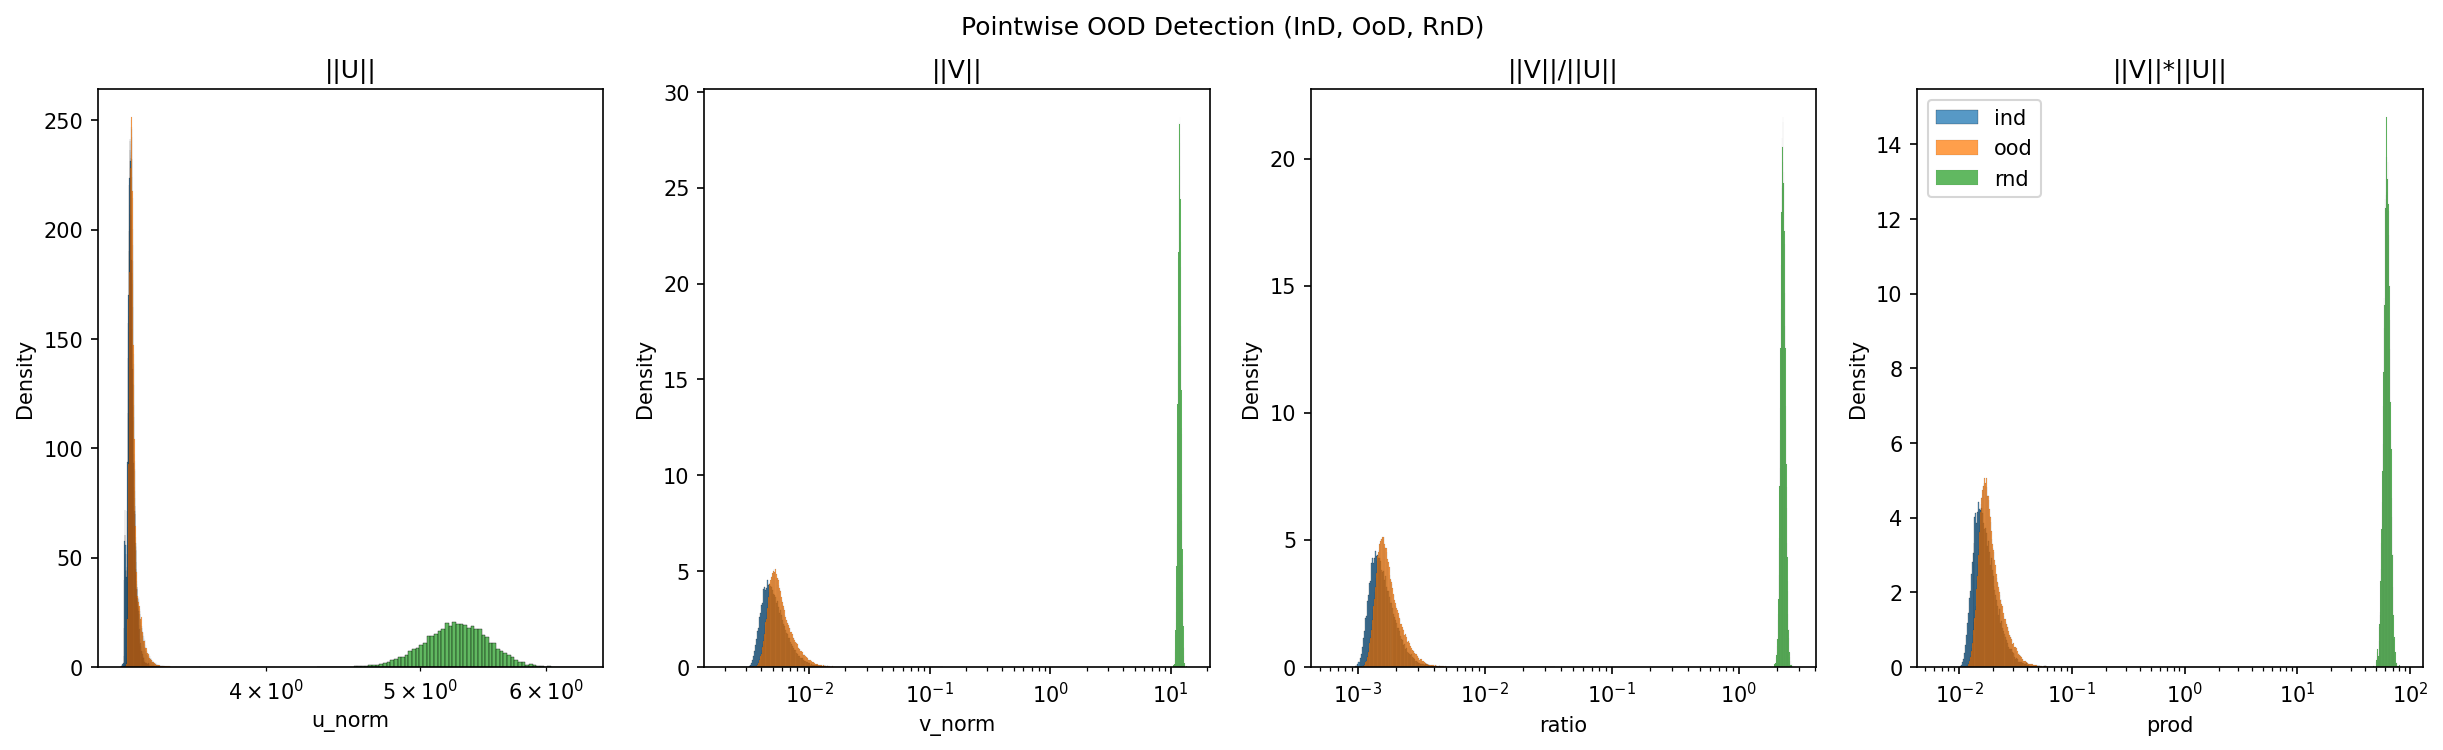

In [12]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

plt.rcParams['figure.figsize'] = (5, 5)
plt.rcParams['figure.dpi'] = 150

data_ind = pd.DataFrame(dict(u_norm=ind_u_norms, v_norm=ind_v_norms, ratio=ind_v_norms/ind_u_norms, prod=ind_v_norms*ind_u_norms, target=ind_targets))
data_ood = pd.DataFrame(dict(u_norm=ood_u_norms, v_norm=ood_v_norms, ratio=ood_v_norms/ood_u_norms, prod=ood_v_norms*ood_u_norms, target=ood_targets))
data_rnd = pd.DataFrame(dict(u_norm=rnd_u_norms, v_norm=rnd_v_norms, ratio=rnd_v_norms/rnd_u_norms, prod=rnd_v_norms*rnd_u_norms))

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (20, 5))
fig.suptitle("Pointwise OOD Detection (InD, OoD, RnD)")

sns.histplot(data=data_ind, x="u_norm", log_scale=True, fill=True, label='ind', stat='density', ax=ax1)
sns.histplot(data=data_ood, x="u_norm", log_scale=True, fill=True, label='ood', stat='density', ax=ax1)
sns.histplot(data=data_rnd, x="u_norm", log_scale=True, fill=True, label='rnd', stat='density', ax=ax1)

sns.histplot(data=data_ind, x="v_norm", log_scale=True, fill=True, label='ind', stat='density', ax=ax2)
sns.histplot(data=data_ood, x="v_norm", log_scale=True, fill=True, label='ood', stat='density', ax=ax2)
sns.histplot(data=data_rnd, x="v_norm", log_scale=True, fill=True, label='rnd', stat='density', ax=ax2)

sns.histplot(data=data_ind, x="ratio", log_scale=True, fill=True, label='ind', stat='density', ax=ax3)
sns.histplot(data=data_ood, x="ratio", log_scale=True, fill=True, label='ood', stat='density', ax=ax3)
sns.histplot(data=data_rnd, x="ratio", log_scale=True, fill=True, label='rnd', stat='density', ax=ax3)

sns.histplot(data=data_ind, x="prod", log_scale=True, fill=True, label='ind', stat='density', ax=ax4)
sns.histplot(data=data_ood, x="prod", log_scale=True, fill=True, label='ood', stat='density', ax=ax4)
sns.histplot(data=data_rnd, x="prod", log_scale=True, fill=True, label='rnd', stat='density', ax=ax4)

ax1.title.set_text('||U||')
ax2.title.set_text('||V||')
ax3.title.set_text('||V||/||U||')
ax4.title.set_text('||V||*||U||')

plt.legend()
plt.show()

In [13]:
from scipy import stats
print("Ind", ind_v_norms.min(), ind_v_norms.max(), ind_v_norms.ptp())
print("Ood", ood_v_norms.min(), ood_v_norms.max(), ood_v_norms.ptp())
print("Rnd", rnd_v_norms.min(), rnd_v_norms.max(), rnd_v_norms.ptp())

ks_ind_ood = stats.kstest(ind_v_norms, ood_v_norms)
print(ks_ind_ood)

Ind 0.0020922413 0.12947838 0.12738614
Ood 0.0020922413 1.4936885 1.4915962
Rnd 10.466671 13.535127 3.0684557
KstestResult(statistic=0.2271732480214335, pvalue=0.0, statistic_location=0.004703017, statistic_sign=1)


[0 1 2 3 4]


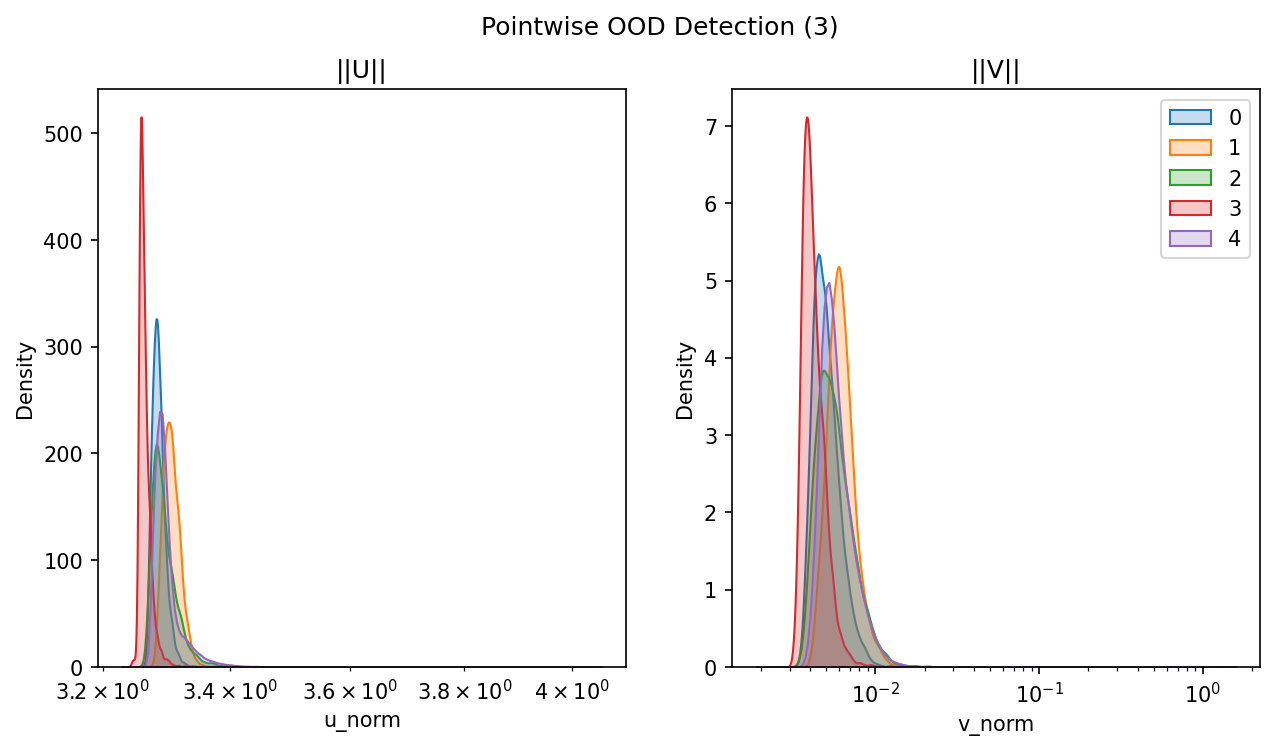

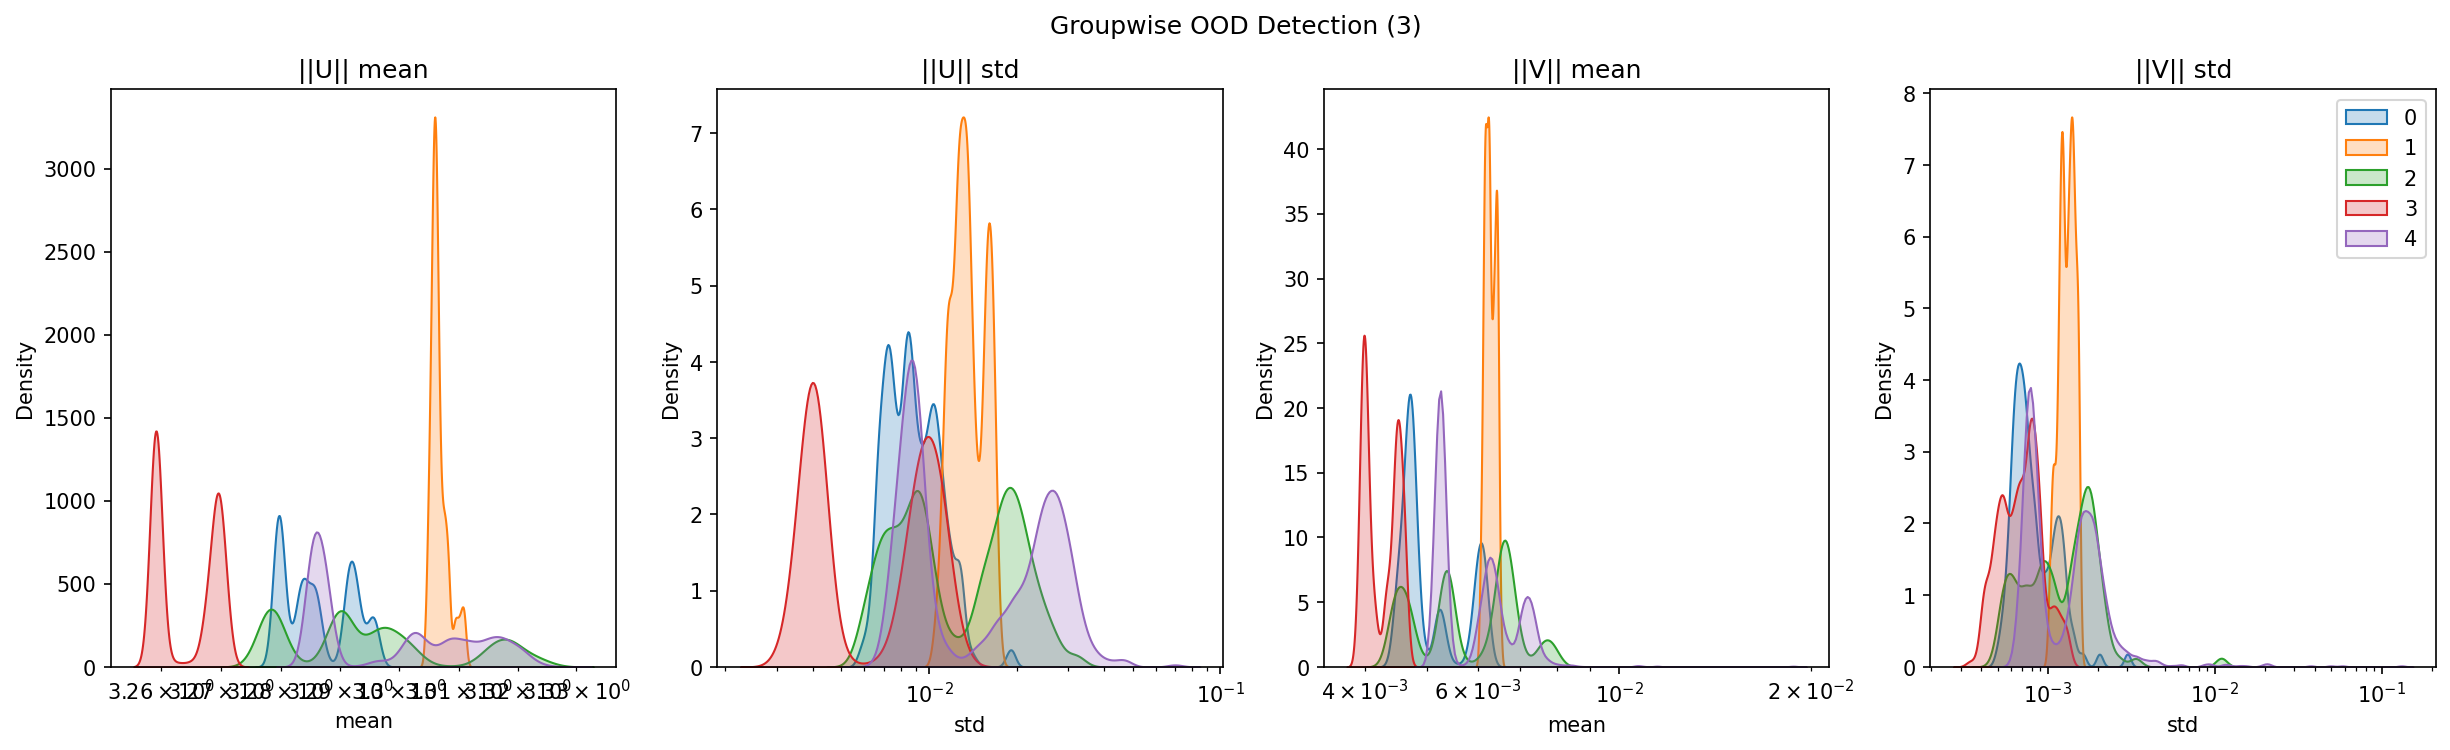

In [14]:
df = pd.concat([data_ind, data_ood], axis=0)
print(df['target'].unique())

N = 128

pointwise = {}
groupwise = {}

for i in range(5):
    df_slice = df[df['target'] == i]
    pointwise[i] = df_slice.copy()
    d = df_slice.rolling(N).agg(['mean', 'std']).dropna()
    groupwise[i] = d.copy()

# pointwise
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
fig.suptitle(f"Pointwise OOD Detection ({':'.join(map(str,config.ood))})")

for i in range(5):
    data = pointwise[i]
    i = str(i)
    sns.kdeplot(data=data, x="u_norm", log_scale=True, fill=True, label=i, ax=ax1)
    sns.kdeplot(data=data, x="v_norm", log_scale=True, fill=True, label=i, ax=ax2)

ax1.title.set_text('||U||')
ax2.title.set_text('||V||')
plt.legend()
plt.show()

    
# groupwise
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (20, 5))
fig.suptitle(f"Groupwise OOD Detection ({':'.join(map(str,config.ood))})")

for i in range(5):
    data = groupwise[i]
    i = str(i)
    sns.kdeplot(data=data.u_norm, x="mean", log_scale=True, fill=True, label=i, ax=ax1)
    sns.kdeplot(data=data.u_norm, x="std", log_scale=True, fill=True, label=i, ax=ax2)
    sns.kdeplot(data=data.v_norm, x="mean", log_scale=True, fill=True, label=i, ax=ax3)
    sns.kdeplot(data=data.v_norm, x="std", log_scale=True, fill=True, label=i, ax=ax4)

ax1.title.set_text('||U|| mean')
ax2.title.set_text('||U|| std')
ax3.title.set_text('||V|| mean')
ax4.title.set_text('||V|| std')
plt.legend()
plt.show()